In [1]:
# Project: Healthcare Sector Sentiment Analysis for Stock Price Prediction
# Dataset: Combined news headlines from DJIA and NASDAQ sources, filtered to healthcare-related headlines.
# The dataset includes:
#   - News headline text
#   - Origin of the headline (DJIA or NASDAQ)

# Goal: Compute a score between 1 and 10 that predicts how well the healthcare sector will perform in the future
# Grand Project Context:
#   These healthcare sentiment scores, along with sentiment scores from other sectors (real estate, finance, food) generated by 
#   other team members, will be one of the inputs into the stock prediction pipeline

In [2]:
# 1. Necessary imports and setup
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
from pathlib import Path
import matplotlib.pyplot as plt


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/opt/homebrew/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2. Data loading - read only the necessary columns from downloaded CSV files,

ARCHIVE_DIR = Path("~/Desktop/SentiStock/archive").expanduser()

djia_file   = ARCHIVE_DIR / "djia_news copy.csv"
nasdaq_file = ARCHIVE_DIR / "nasdaq.csv"

df_djia   = pd.read_csv(djia_file,   usecols=["Ticker", "Headline"])
df_nasdaq = pd.read_csv(nasdaq_file, usecols=["Ticker", "Headline"])

df_djia["Source"]   = "DJIA"
df_nasdaq["Source"] = "NASDAQ"

df_all = pd.concat([df_djia, df_nasdaq], ignore_index=True)

In [4]:
# 3. Inspect the loaded data
print("DJIA news sample:")
print("DJIA news sample:")
display(df_djia.head())

print("NASDAQ news sample:")
display(df_nasdaq.head())

DJIA news sample:
DJIA news sample:


,Ticker,Headline,Source
0,MMM,Employer who stole nearly $3M in wages from 15...,DJIA
1,MMM,Huge new Facebook data leak exposed intimate d...,DJIA
2,MMM,A campaign has accelerated to turn a disused r...,DJIA
3,MMM,Google launches global human trafficking helpl...,DJIA
4,MMM,Over 3m Saudi Women Don’t Have ID Cards; Saudi...,DJIA


NASDAQ news sample:


,Ticker,Headline,Source
0,A,@TotesTravel : Airline shares tumble as New Yo...,NASDAQ
1,A,@TotesTravel : American United call off Hong K...,NASDAQ
2,A,@TotesTravel : U.S. airline stocks hit highest...,NASDAQ
3,A,@TotesTravel : American Airlines reaches deal ...,NASDAQ
4,A,@TotesTravel : US airlines Treasury Department...,NASDAQ


In [5]:
# 4. Goal: Filter headlines to only those mentioning healthcare-related terms
hc_terms = [
    "healthcare", "patient", "medicine", "hospital", "clinic",
    "doctor", "nurse", "pharma", "vaccine", "treatment"
]
pattern = "|".join(hc_terms)

df_hc = df_all[df_all["Headline"].str.lower().str.contains(pattern)].copy()

display(df_hc.head())

,Ticker,Headline,Source
48,MMM,Industry Cites 3M experiment that exposed canc...,DJIA
75,MMM,Canadian PM Justin Trudeau has said he will no...,DJIA
181,AMGN,Amgen exits neuroscience R&amp;D as pharma pul...,DJIA
187,AMGN,From Amgen to Gilead drugmakers are sitting on...,DJIA
229,AAPL,France To Take Legal Action Against Facebook G...,DJIA


In [6]:
# 5. Load the FinBERT model and tokenizer for finance-specific sentiment analysis.

sent_pipe = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert",
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

def to_scale_1_10(scores):
    """
    Convert whatever FinBERT gives us into a [1,10] score:
    - NEGATIVE  → weight −1
    - NEUTRAL   → weight  0
    - POSITIVE  → weight +1
    Then linearly map from [-1,1] to [1,10].
    """
    label2score = {item["label"].upper(): item["score"] for item in scores}
    neg = label2score.get("NEGATIVE", 0.0)
    pos = label2score.get("POSITIVE", 0.0)
    sentiment = pos - neg
    return float((sentiment + 1) * 4.5 + 1)

Device set to use cpu
/opt/homebrew/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
# 6. Apply the sentiment pipeline in batches, convert to numeric scores, and attach back to our healthcare subset for analysis.
texts = df_hc["Headline"].tolist()
all_scores = sent_pipe(texts, batch_size=32)

df_hc["Sentiment_1_10"] = [to_scale_1_10(s) for s in all_scores]
display(df_hc[["Ticker","Headline","Sentiment_1_10"]].head())

pred_score = df_hc["Sentiment_1_10"].mean()

,Ticker,Headline,Sentiment_1_10
48,MMM,Industry Cites 3M experiment that exposed canc...,6.268280
75,MMM,Canadian PM Justin Trudeau has said he will no...,1.919778
181,AMGN,Amgen exits neuroscience R&amp;D as pharma pul...,3.530897
187,AMGN,From Amgen to Gilead drugmakers are sitting on...,5.954112
229,AAPL,France To Take Legal Action Against Facebook G...,1.296438


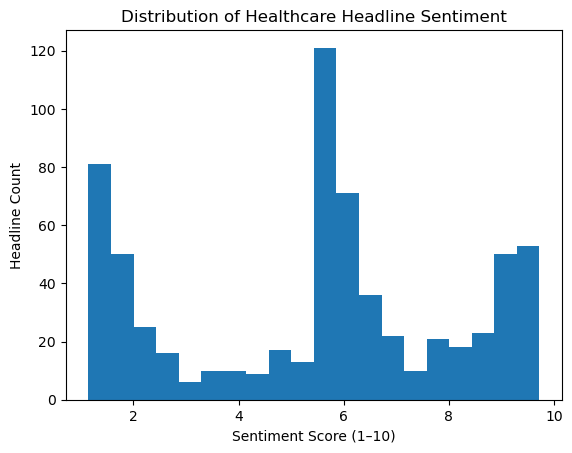

In [8]:
# 7. Visualize how sentiment scores are spread across all healthcare headlines
plt.figure()
plt.hist(df_hc["Sentiment_1_10"], bins=20)
plt.xlabel("Sentiment Score (1–10)")
plt.ylabel("Headline Count")
plt.title("Distribution of Healthcare Headline Sentiment")
plt.show()

In [12]:
# 7. Save the healthcare-only sentiment scores to CSV
output_file = ARCHIVE_DIR / "healthcare_sentiment.csv"
df_hc.to_csv(output_file, index=False)
print(f"Saved healthcare sentiment data to {output_file}")

Saved healthcare sentiment data to /Users/nataliasurzhak/Desktop/SentiStock/archive/healthcare_sentiment.csv
